[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/master/2404_ICTP/1-vmc-from-scratch-nosolution.ipynb)

# VMC-from-scratch: Finding Ground-States

The goal of this tutorial is to try to write a simple VMC code from (almost) scratch to compute the ground-state of a paradigmatic spin model: the spin-$1/2$ Heisenberg antiferromagnetic chain.
Normally, to write a VMC code you would have to implement yourself a way to compute matrix elements of the operators, as well as code to run a Monte-Carlo sampler, but for sanity and peace of mind in this tutorial we will use NetKet to do it.

The hamiltonian we will study in this example is the transverse-field Ising model in 2 dimensions:

$$
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}.
$$

In the following we assume periodic boundary conditions.

The tutorial is structured in such a way that you need to fill in some parts by yourself to make it work. The solutions can be found hidden in [this page of the NetKet documentation](https://netket.readthedocs.io/en/latest/tutorials/vmc-from-scratch.html)

:::{note}
If you are executing this notebook on **Colab**, you will need to install NetKet.
You can do so by uncommenting and running the following cell.

Keep in mind that this notebook was designed for NetKet version `3.9.1`, which requires Python >=3.8. If you do not have access to a recent version of Python we strongly recomend to run this notebook on google Colab.
:::

In [1]:
%pip install --quiet netket

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.1/687.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.1 MB/s eta 0:00:00


Please verify that you are running on the correct version of NetKet. If the installation installed an older version of NetKet, it might be because your Python version is too old.
In that case, you will need to upgrade python or use Colab.

It might also be that in the future NetKet changes. This notebook was authored for the following version of NetKet:

In [2]:
import platform
import netket as nk

print("Python version (requires >=3.9)", platform.python_version())
print("NetKet version (requires >=3.9.1)", nk.__version__)

Python version (requires >=3.9) 3.10.12
NetKet version (requires >=3.9.1) 3.15.0


*After* having defined this environment variable, we can load netket and the various libraries that we will be using throughout the tutorial.

## 0. What is NetKet?

[NetKet](http://www.netket.org) is a comprehensive package that we (a group of approximately 10 researchers) developed over the years to perform Variational Monte Carlo calulations, while hiding varying degrees of complexity from the researchers that don't want to get their hands too dirty with nitty gritty details.
Our idea is that if we lower the barrier to use variational monte carlo methods, more researchers will start playing with them, and, only if the want, they will get down to the little details.

Remarkably, renowed researchers like Dr. Alessandro Lovato are large proponents of not using netket, wanting to kontrol every little detail in their codes. While I partly agree with Alessandro, I am a strong proponent of hiding complexity unless needed, and this exercise will reflect this idea.

NetKet is throughly documented in [its publication](https://scipost.org/SciPostPhysCodeb.7/pdf) and partly in its [online documentation](https://netket.readthedocs.io/en/latest/index.html). When in doubt, check those, and if you find no answer, ask on our official [discussion forum](https://github.com/orgs/netket/discussions).

I suggest you look at the first tutorial from NetKet, the Ising model ground state one, before adventuring in this one.

In [3]:
# Import netket library
import netket as nk

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# jax and jax.numpy
import jax
import jax.numpy

## 1. Defining the Hamiltonian

NetKet covers quite a few standard Hamiltonians and lattices, so let's use this to quickly define the Ising model on a 2D lattice with PBC.
For the moment we assume $L=4$ ($N=16$) and simply define a chain lattice in this way (using periodic boundary conditions for now).
NetKet also implements many different lattices. Check them out in [the API reference](https://netket.readthedocs.io/en/latest/api/graph.html).

In [4]:
# We always shorten netket as nk
import netket as nk

# Define a 1d chain
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

For a comprehensive look at the functionalities of a graph object, you can look at the API reference of the [Graph](https://netket.readthedocs.io/en/latest/api/_generated/graph/netket.graph.Graph.html#netket.graph.Graph) and [Lattice](https://netket.readthedocs.io/en/latest/api/_generated/graph/netket.graph.Lattice.html#netket.graph.Lattice) objects.

The graph object is handy to quickly write the hamiltonian because it gives you easy access to the vertices (called nodes) and edges of the graph:

In [5]:
# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


Finally, you can also look at the lattice in all its glory

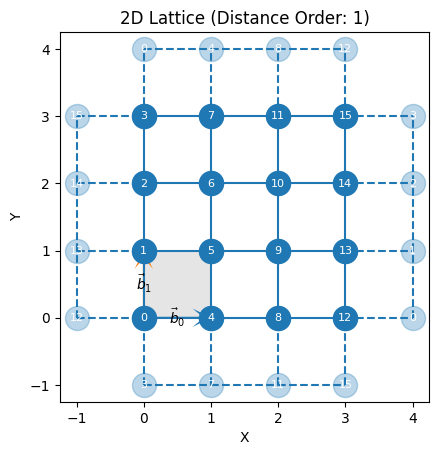

In [6]:
g.draw();

Remember about those things. They will be useful later.

Next, NetKet asks us to define the computational space (or basis) for this calculation.

In [7]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

<ipython-input-7-6019de13a831>:3: UndeclaredSpinOderingWarning: 
You have not explicitly specified the spin ordering for the Hilbert space.
The default behaviour is currently `-1=↑, 1=↓`, but it will be changed 1st january 2025 to `1=↑, -1=↓`.

- To maintain the current behaviour in the future, specify `inverted_ordering=True` (this
    allows you to load NN parameters you have saved in the past)
- To opt-in today in the future default, specify `inverted_ordering=False` (so your code will
    work without changes in the future)

If you do not care about this warning, you can silence it by setting the environment variable
`NETKET_SPIN_ORDERING_WARNING=0` or by executing `nk.config.netket_spin_ordering_warning = False`

This warning will be shown once per day during interactive sessions, and always in scripts and MPI/SLURM jobs unless silenced.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.

This is somewhat a fundamental object, and you must often declare it. Mainly, it defines how many degrees of freedom you have and how you store configurations. In this case, the hilbert space stores them as a local variable +1 or -1.

Then we must define the Hamiltonian. In NetKet you can build individual operators acting on a site by calling the following three functions

In [8]:
sx_1 = nk.operator.spin.sigmax(hi, 1)
sy_2 = nk.operator.spin.sigmay(hi, 2)
sz_2 = nk.operator.spin.sigmaz(hi, 2)

The functions in `nk.operator.spin` and `nk.operator.boson` are used to create the fundamental operators that can be used to build arbitrary observables and Hamiltonians.
Those functions return an object of type [LocalOperator](https://netket.readthedocs.io/en/latest/api/_generated/operator/netket.operator.LocalOperator.html#netket.operator.LocalOperator), which behaves as some sort of sparse matrix that is optimised to be used in the context of Variational Monte Carlo.

:::{note}
A `LocalOperator` can efficiently represent only operators that have a small domain in the computational basis: this means that an operator acting on 1 or 2 qubits will be efficiently represented, but one that acts on many qubits at once will not be.

This is particularly important for operators such as projectors on a single configuration, such as $ |\sigma_1\dots \sigma_N\rangle \langle \sigma_1\dots \sigma_N| $, or projectors on an arbitrary wave-function.
Those cannot be efficiently represented as LocalOperators.

NetKet also implements other types of operators, which have a different cost/complexity scaling. Look at the published paper for more informations.
:::

A LocalOperator can be printed, and has the following representation:

In [9]:
print(sx_1)

LocalOperator(dim=16, acting_on=[(1,)], constant=0.0, dtype=float64)


The informations you see tells you that:
 * `dim`: The hilbert space has 16 local degrees of freedom
 * `acting_on`: this specific operator is composed by terms that act on the single site 1
 * `constant`: this is a diagonal shift proportional to the identity. In this case it is 0
 * `dtype`: the numpy data-type of the matrix elements. This allows you to store operators in single or double precision, or as real or complex valued operators. For most use cases, you can not worry about this, but if you want to squeeze every last drop of performance from a GPU you should pay attention to this.

You then can combine those operators together together by multiplying, adding them or subtracting them. Try to build the Transverse field ising hamiltonian by combining those operators while iterating through the edges in the lattice.

$$
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}.
$$

where $h=1$ and $J=1$ .
Now it's your turn.

Try to convert the equation above to code, using the operators that were discussed before (`nk.operator.spin.sigmax` and `nk.operator.spin.sigmaz`).

Try to complete the code below:

In [10]:
# This creates an empty operator (or zero) to which you can add others.
hamiltonian = nk.operator.LocalOperator(hi)

# now add all terms acting on single sites
hx, hy = 0.5, 0.5
for site in g.nodes():
  hamiltonian = hamiltonian - hx*nk.operator.spin.sigmax(hi, site) - hy*nk.operator.spin.sigmay(hi, site) # every node (take the list of nodes from the graph object g that we constructed before)
    # TODO

    # now add all terms acting on multiple sites
for (i,j) in g.edges(): # every edge (take the list of edges from the graph object)
    hamiltonian += nk.operator.spin.sigmaz(hi,i) @ nk.operator.spin.sigmaz(hi,j) # TODO


To check if your implementation is correct, you can run this following line.
It will error if your implementation is wrong.

In [21]:
import numpy as np

hamiltonian_correct = nk.operator.Ising(hi, g, h=1.0, J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5

AssertionError: 

Most operators in NetKet are implemented in Numba and they are not compatible with `jax.jit`. However, some particular operator formats are implemented both in `numba`and in a `jax.jit-`compatible format.

To make the rest of the tutorial easier on the reader, we will now convert the operator to a format that makes those operators jax-friendly, such that you can pass them to jax functions without problems.

To do this, first we convert your hamiltonian from the `LocalOperator` format to the `PauliStrings` format by calling `.to_pauli_strings()`, and then we convert the `PauliStrings` operator to the jax format by calling `to_jax_operator()`.

The reason why we have so many formats for operators is because they have different performance characteristics that even we don't fully understand completely. We give users several possible choices such that the user can try and find the best for his use-case.

In [11]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

You can also convert those operators to sparse. You will get a `jax.experimental.sparse` matrix.

In [12]:
hamiltonian_jax.to_sparse()

BCSR(complex128[65536, 65536], nse=1114112)

## 2. Exact Diagonalization (as a testbed)

Just as a matter of future comparison, let's compute the exact ground-state energy (since this is still possible for up to $N=24$ sites using brute-force exact diagonalization).

You can convert your operator to a sparse matrix with the method `.to_sparse()`. Now use scipy to diagonalise it and extract the lowest eigenvalue.

Note that the standard hamiltonian `hamiltonian` can be converted to a scipy sparse matrix easily, while the jax-hamiltonian `hamiltonian_jax` is converted to a jax sparse matrix. Therefore chose wisely what format you want to use for exact diagonalisation!

In [14]:
# TODO

# compute the two values
e_gs, psi_gs

(-33.00262560818493,
 array([4.14116986e-09+3.24385934e-09j, 3.64543994e-09+3.00030796e-08j,
        3.64551169e-09+3.00027051e-08j, ...,
        3.00030796e-08-3.64543990e-09j, 3.00027051e-08-3.64551167e-09j,
        4.14116976e-09+3.24385897e-09j]))

In [13]:
# todelete
from scipy.sparse.linalg import eigsh
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1)
e_gs = e_gs[0]
psi_gs = psi_gs.reshape(-1)
e_gs

-33.00262560818493

In [ ]:
# if all is good, this cell should validate
assert e_gs.shape == ()
assert psi_gs.shape == (hi.n_states, )
assert -34.01060 < e_gs < -34.01059

## 3. Variational Ansatz & variational energy

In this section I would like to guide you to write a small code to compute the energy given a variational ansatz.
The calculation should be done exactly, but structured in a set of functions as I will suggest you...

First, let's define the variational ansatz. This time I write it. Later you will have to write one yourself.

### 3.1 Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz:

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i), $$

where the variational parameters are the single-spin wave functions, which we can further take to be normalized:

$$ |\Phi(\uparrow)|^2 + |\Phi(\downarrow)|^2 =1, $$

and we can further write $ \Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}$. In order to simplify the presentation, we take here and in the following examples the phase $ \phi=0 $. In this specific model this is without loss of generality, since it is known that the ground state is real and positive.

For the normalized single-spin probability we will take a sigmoid form:

$$ P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z)), $$

thus depending on the real-valued variational parameter $\lambda$.
In NetKet one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).
We call this variational function _the Model_ (yes, caps on the M).

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right], $$

where $\theta$ is a set of parameters.
In this case, the parameter of the model will be just one: $\lambda$.  

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku.
NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), so we will be using it for the rest of the notebook.

In [15]:
import jax

# numerical operations in the model should always use jax.numpy
# instead of numpy because jax supports computing derivatives.
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):

    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as
    # input a batch of states x.shape = (n_samples, N)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):

        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values.
        # - The shape of the tensor
        # - The dtype of the tensor.
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )

        # compute the probabilities
        p = nn.log_sigmoid(lam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result.

To initialise the parameters we do the following:

In [16]:
# create an instance of the model
model = MF()

# pick a RNG key to initialise the random parameters
key = jax.random.key(0)

# initialise the weights
parameters = model.init(key, np.random.rand(hi.size))

In [ ]:
# parameters are stored as a 'pytree', that is, a dictionary of dictionaries whose leafs are numerical arrays

In [17]:
parameters

{'params': {'lambda': Array([-0.02033396], dtype=float64)}}

Conceptually, parameters are vectors, even though they are stored in memory differently. You can apply mathematical operations to those vectors using `jax.tree.map(function, trees...)`, which calls the function on every element of the pytrees.

In [18]:
dict1 = {'a':1, 'b':2}
dict2 = {'a':1, 'b':-2}

def multiply_by_10(x):
    return 10*x

print("multiply_by_10:             ", jax.tree.map(multiply_by_10,  dict1))
# this can also be done by defining the function as a lambda function, which is more compact
print("multiply_by_10, with lambda:", jax.tree.map(lambda x: 10*x,  dict1))

def add(x,y):
    return x+y
print("add dict1 and 2          :", jax.tree.map(add, dict1, dict2))


def sub(x,y):
    return x-y
print("subtract dict1 and 2        :", jax.tree.map(sub, dict1, dict2))
print("subtract dict1 and 2, lambda:", jax.tree.map(lambda x,y:x-y, dict1, dict2))


multiply_by_10:              {'a': 10, 'b': 20}
multiply_by_10, with lambda: {'a': 10, 'b': 20}
add dict1 and 2          : {'a': 2, 'b': 0}
subtract dict1 and 2        : {'a': 0, 'b': 4}
subtract dict1 and 2, lambda: {'a': 0, 'b': 4}


To evaluate the model for some parameters and a set of inputs you do the following

In [19]:
# generate 4 random inputs
inputs = hi.random_state(jax.random.key(1), (4,))

log_psi = model.apply(parameters, inputs)
# notice that logpsi has shape (4,) because we fed it 4 random configurations.
print(log_psi.shape)

(4,)


### 3.2. Your turn

Remember that your function `model.apply` will evaluate `logpsi`, not the wavefunction itself.

Write a function that takes as input the model and the parameters, and which returns the exponentiated wavefunction, properly normalised.


In [45]:
# TODO
import jax.numpy as jnp
from jax import jit

def to_array(model, parameters): # -> Array:
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()


    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi

In [21]:
# If you did it correctly, this test should pass

assert to_array(model, parameters).shape == (hi.n_states, )
assert np.all(to_array(model, parameters) > 0)
np.testing.assert_allclose(np.linalg.norm(to_array(model, parameters)), 1.0)

If you implemented everything correctly using `jnp.` operations and not `np.` operations, we might as well be able to jit-compile the function to gain a speed boost!
Try the following

In [22]:
%timeit to_array(model, parameters)

28.9 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


that's quite slow. Instead we can compile it by doing

In [23]:
# static_argnames must be used to tag any argument that is not a pytree or an array. In this case, the model.
to_array_jit = jax.jit(to_array, static_argnames="model")

# run it once to compile it, before benchmarking
to_array_jit(model, parameters)

Array([0.0042355 , 0.00419265, 0.00419265, ..., 0.0036364 , 0.0036364 ,
       0.00359962], dtype=float64)

And it should already be a bit faster. Moreover, the speedup will be even larger when computing gradients or other complicated operations.

In [24]:
%timeit to_array_jit(model, parameters)

25.9 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 3.3 Energy
Now, using that function, let's build another one that computes the energy of the mean field state for the given parameters!
To do that, you can for example convert the hamiltonian to a sparse format and compute the energy

In [49]:
# todo
def compute_energy(model, parameters, hamiltonian):
    psi_gs = to_array(model, parameters)
    # todo
    return jnp.conj(psi_gs).T @ (hamiltonian_jax_sparse @ psi_gs)

In [50]:
# if all is good, this should not error
assert compute_energy(model, parameters, hamiltonian.to_sparse()).shape == ()
assert compute_energy(model, parameters, hamiltonian.to_sparse()) < 0

In [51]:
# and like before, we can jit-compile it!
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

Again, to show that jitting is useful, We can time the jitted and non-jitted versions.

In [52]:
%timeit compute_energy(model, parameters, hamiltonian_sparse)
%timeit compute_energy_jit(model, parameters, hamiltonian_jax_sparse)

698 ms ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.15 times longer than the fastest. This could mean that an intermediate result is being cached.
43.2 µs ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3.4 Gradient of the energy

As we used jax so far, we can easily compute the gradient of the energy by simply calling one function: `jax.grad(compute_energy, argnum=1)`, where argnum signals wrt which argument we want to compute the gradient (the 0 is the model, which is not actually an array so we cannot differentiate, the second is the parameters, so that's the one

In [44]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
@partial(jax.jit, static_argnames='model')
def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    return grad_fun(model, parameters, hamiltonian_sparse)

In [45]:
energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
print(gradient)

NotImplementedError: bcsr_dot_general currently implemented for BCSR lhs and ndarray rhs.

notice that we now have the same 'structure' as the parameters

### 3.5 Optimise and look for the ground state

Now write a little code to initialise the model, find the groundstate and plot the energy along the optimisation.

Iterate for 100 iterations, and use `tqdm` to print a beautiful error bar.

In [ ]:
from tqdm import tqdm

# initialise
model = MF()
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(iterations)):
    # compute energy and gradient
    #...

    # update parameters. Try using a learning rate of 0.01
    # to update the parameters, which are stored as a dictionary (or pytree)
    # you can use jax.tree.map as shown above.
    #...

    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy' : energy})

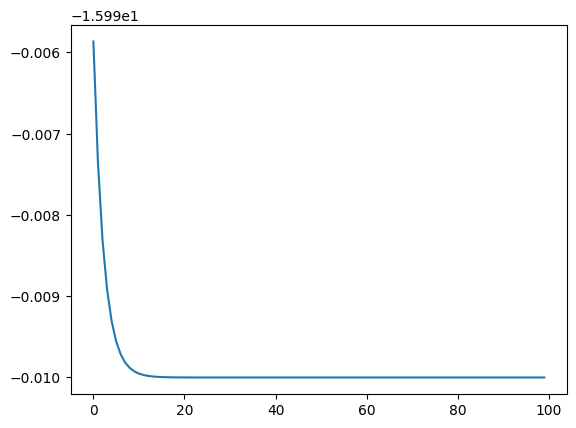

In [ ]:
import matplotlib.pyplot as plt

# to plot the data, access it!
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['value'])

But actually a better plot would be the relative error in log-scale, because it allows us to better see what is going on at all scales and compare different runs.

Try to do it yourself!

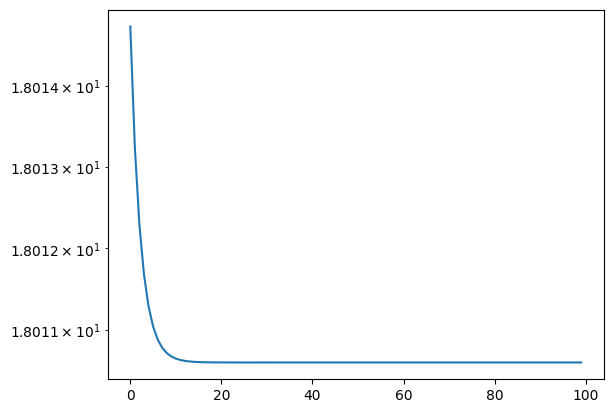

In [ ]:
import matplotlib.pyplot as plt

# to plot the data, access it!
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value']- e_gs))

### 3.6 Jastrow Ansatz

Now try running the same caluclation as above, but by using a Jastrow ansatz instead of a mean Field ansatz. Write it using flax as before.

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp \left( \sum_{ij}\sigma_i J_{ij}\sigma_j\right),$$


In [ ]:
# A Flax model must be a class subclassing `nn.Module`
class Jastrow(nn.Module):

    # The most compact way to define the model is this.
    # The __call__(self, input_x) function should take as
    # input a batch of states input_x.shape = (n_samples, N)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, input_x):

        n_sites = input_x.shape[-1]

        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values.
        # - The shape of the tensor
        # - The dtype of the tensor.
        # Define the two variational parameters J1 and J2
        J = self.param(
            "J", nn.initializers.normal(), (n_sites,n_sites), float
        )
        # ensure same data types
        dtype = jax.numpy.promote_types(J.dtype, input_x.dtype)
        J = J.astype(dtype)
        input_x = input_x.astype(dtype)

        # note that J_ij is not symmetric. So we symmetrize it by hand
        J_symm = J.T + J

        # TODO compute the result
        res = # use vectorised operations. Make sure they work with arbitrary shapes of dimensions.
        # look into jnp.einsum.

        return res

In [ ]:
# if the code above is correct, this should run
model_jastrow = Jastrow()

one_sample = hi.random_state(jax.random.key(0))
batch_samples = hi.random_state(jax.random.key(0), (5,))
multibatch_samples = hi.random_state(jax.random.key(0), (5,4,))

parameters_jastrow = model_jastrow.init(jax.random.key(0), one_sample)
assert parameters_jastrow['params']['J'].shape == (hi.size, hi.size)
assert model_jastrow.apply(parameters_jastrow, one_sample).shape == ()
assert model_jastrow.apply(parameters_jastrow, batch_samples).shape == batch_samples.shape[:-1]
assert model_jastrow.apply(parameters_jastrow, multibatch_samples).shape == multibatch_samples.shape[:-1]

**And now rerun the same analysis as before but with this ansatz*

## 4. Monte Carlo complications

Until now we did everything by summing over the whole hilbert space, but for larger problems that won't be possible. So let's look into MC sampling.

### 4.1 Generating samples

For this tutorial, we won't look into the nitty gritty details of sampling, but instead rely on a set of samplers already written for us. Let's consider a simple MCMC sampler that propose new states by flipping individual spins

In [ ]:
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)

And the samplers are used as follows:
 - First you initialise the 'sampler state' that contains the mutable state and rng of the sampler
 - Every time you change the parameters you reset it
 - to generate new samples you call .sample_chain.

In [ ]:
sampler_state = sampler.init_state(model, parameters, seed=1)
sampler_state = sampler.reset(model, parameters, sampler_state)
samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=100)

print(samples.shape)
# those are the three dimensions: 20 chains, 100 length per chain and 16 spins per sample.
# Note: chains are sometimes refereed to as walkers
# Note: the chain length is actually the length of the returned samples. In reality, the sampler generates
# chains of length `chain_length * sampler.sweep_size` and returns you 1 sample every   sampler.sweep_size

(20, 100, 16)


To generate more samples, simply call `sampler.sample` again or with a different `chain_length`.
If you change the parameters, you should call `sampler.reset`.

### 4.2 Computing the Energy

We want to compute the energy as an expectation value, therefore as

$$
   E = \sum_i^{N_s} \frac{E_\text{loc}(\sigma_i)}{N_s}
$$

where $\sigma_i$ are the samples and Eloc is

$$
  E_\text{loc}(\sigma) = \frac{\langle \sigma |H|\psi\rangle}{\langle \sigma |\psi\rangle} = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)}
$$

but the sum in principle is over exponentially many entries. Instead we can do the following

$$
  E_\text{loc}(\sigma) = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)} = \sum_{\eta\,\, \text{s.t.} \,\,\langle\sigma|H|\eta\rangle \neq 0} \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)}
$$


Those entries can be extracted through our 'special' operators.

In [ ]:
# given sigma
sigma = hi.random_state(jax.random.key(1))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

In [ ]:
# so for 1 sample sigma
print(sigma.shape)

# we have 17 connected samples eta, each composed by 16 spins
print(eta.shape)
# and 17 matrix elements
print(H_sigmaeta.shape)

(16,)
(17, 16)
(17,)


This also applies for batches of configurations

In [ ]:
# given sigma
sigma = hi.random_state(jax.random.key(1), (4,5))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

# so for each of the (4,5) samples sigma each of 16 spins
print(sigma.shape)

# we have 17 connected samples eta, each composed by 16 spins, in a tensor of shape (4,5,17,16)
print(eta.shape)
# and 17 matrix elements
print(H_sigmaeta.shape)

(4, 5, 16)
(4, 5, 17, 16)
(4, 5, 17)


_TODO_: Now use this `get_conn_padded` to write a function that computes the local energy given a model and a set parameters

$$
  E_\text{loc}(\sigma) = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)} = \sum_{\eta\,\, \text{s.t.} \,\,\langle\sigma|H|\eta\rangle \neq 0} \langle\sigma|H|\eta\rangle \exp[\log\psi(\eta) - \log\psi(\sigma)]
$$


In [ ]:
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

    logpsi_sigma = ...
    logpsi_eta = ...

    # to match their dimensions and broadcast, jnp.expand_dims(logpsi_sigma, -1) might help
    ...

    return res

In [ ]:
# if you wrote it correctly, you should get to work the following tests
assert compute_local_energies(model, parameters, hamiltonian_jax, samples[0]).shape == samples.shape[1:-1]
assert compute_local_energies(model, parameters, hamiltonian_jax, samples).shape == samples.shape[:-1]

In [ ]:
# and if you did not do crazy things, this should also jit compile
jax.jit(compute_local_energies, static_argnames='model')(model, parameters, hamiltonian_jax, sigma)

Array([[-20., -16., -12., -20., -12.],
       [-16., -12., -16., -16., -12.],
       [-16., -16., -12., -20., -24.],
       [-16., -20., -24., -16., -12.]], dtype=float64)

### 4.3 Sampling the energy

So now write a function that computes the energy and estimates its error. I remind you that the error is given by

$$
    \epsilon_E = \sqrt{\frac{\mathbb{V}\text{ar}(E_\text{loc})}{N_\text{samples}}}
$$

In [ ]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)

    E_average = ...
    E_variance = ...
    E_error = ...

    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

In [ ]:
# this should run correctly
isinstance(estimate_energy(model, parameters, hamiltonian_jax, samples), nk.stats.Stats)
print(estimate_energy(model, parameters, hamiltonian_jax, samples))

-16.00 ± 0.13 [σ²=31.31]


we can also check that by increasing the number of samples, we get a good prediction within the standard error of the 'full summation' calculations

In [ ]:
samples_many, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=5000)

print("exact: ", compute_energy(model, parameters, hamiltonian_jax))
print("Estimate: ", estimate_energy(model, parameters, hamiltonian_jax, samples_many))


exact:  -15.999999999999408
Estimate:  -15.979 ± 0.018 [σ²=31.965]


### 4.4 Sampling the gradient of the energy

We have seen during the class that the gradient of the energy can be estimated according to the formula

$$
    \nabla_k E = \mathbb{E}_{\sigma\sim|\psi(\sigma)|^2} \left[ (\nabla_k \log\psi(\sigma))^\star \left( E_\text{loc}(\sigma) - \langle E \rangle\right)\right] \approx \frac{1}{N_s}\sum_i^{N_s} (\nabla_k \log\psi(\sigma_i))^\star \left( E_\text{loc}(\sigma_i) - \langle E \rangle\right)
$$

Where $\langle E \rangle$ can be estimated as $\langle E \rangle \approx \frac{1}{N_s}\sum_i E_\text{loc}(\sigma_i)$

Now, for a second, think of $\nabla_k \log\psi(\sigma_i)$ as the _JACOBIAN_ of the function $\log\psi_\sigma : \mathbb{R}^{N_\text{pars}} \rightarrow \mathbb{R}^{N_\text{samples}}$, and think for a moment of $E_\text{loc}(\sigma_i)$ as a vector of size $\mathbb{R}^{N_\text{samples}}$

In [ ]:
# reshape samples in a vector of size (N_pars x N)
sigma_vector = samples.reshape(-1, hi.size)

# lets see that function logpsi_sigma
logpsi_sigma_fun = lambda pars : model_jastrow.apply(parameters_jastrow, sigma_vector)

# input to the function are only the parameters, output is a vector of size n samples
print("N_samples is equal to: ", logpsi_sigma_fun(parameters_jastrow).shape)

N_samples is equal to:  (2000,)


So we can compute the jacobian of this function!

In [ ]:
jacobian = jax.jacrev(logpsi_sigma_fun)(parameters_jastrow)

#
print("The parameters of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, parameters_jastrow))

print("The jacobian of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, jacobian))

The parameters of jastrow have shape:
 {'params': {'J': (16, 16)}}
The jacobian of jastrow have shape:
 {'params': {'J': (2000, 16, 16)}}


Now implement a function that computes the jacobian-vector product in order to estimate the gradient of the energy. You can either do this vector-Jacobian-transpose product manually by using `jax.jacrev` and `jax.tree.map`, but you can also have a look at `jax.vjp` which does it automatically for you.

In [ ]:
## TODO

# @partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])

    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)

    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model_jastrow.apply(parameters_jastrow, sigma_vector)
    ...
    # use jacrev with jax.tree.map, or even better, jax.vjp
    E_grad = ...

    # compute the energy as well
    E_average = ...
    E_variance = ...
    E_error = ...
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

    return E, E_grad

If you are a fast person, Try to implement this function both usin `jax.jacrev` and `jax.vjp` and try to see which one is faster. You might need to benchmark it for different Neural Networks...

### 4.5: Let's get down to business

Now let's wrap everything up and let's use this code to compute the ground state with an SGD optimisation using the mean field and jastrow ansatz

In [ ]:
from tqdm import tqdm

# settings
model = MF()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)

    # compute energy and gradient
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)

    # update parameters. Try using a learning rate of 0.01
    # ... implement it!

    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy' : E})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 129.40it/s]


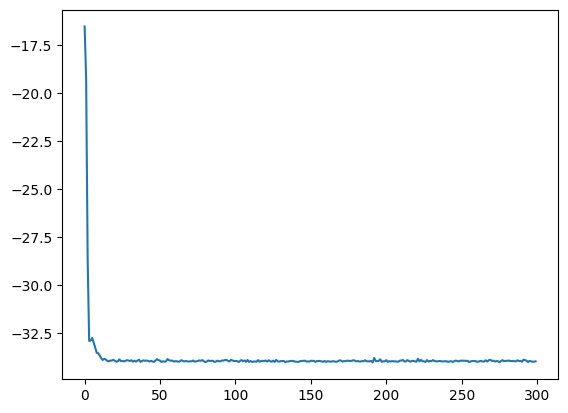

In [ ]:
# to plot the data, access it!
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])

## 5 : Future things to try

### 5.1 : Try to implement a FeedForward network

Try to use flax to implement a simple Feed Forward Neural Network with 1 or 2 layers and becnhmark it. Look at the documentation and try using some `nn.Dense` layers together with some activation functions of your choice. Try going for something like a 2 layers Dense with `relu` activation function and a final pooling operation.

### 5.2: Try better optimisers

There is a library, [optax](https://optax.readthedocs.io/en/latest/), that implements several optimisers.
Try to use adam or other optimisers.
The way you use them is as follows:

In [ ]:
import optax

# define
optimizer = optax.adam(learning_rate=0.01)

# initialise
parameters = model.init(...)
optimizer_state = optimizer.init(parameters)

for i in range(n_iters):
    E, E_grad = estimate_energy_and_grad(..., parameters, ...)

    updates, optimizer_state = optimizer.update(E_grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)


### 5.3: Sky's the limit

What you've seen so far gives you the tools to quickly get started in running VMC calculations, without having to worry about sampling (which is a bit tricky to implement) and operators (which are very tricky to implement).

You can use this as a starting point to implement stochastic reconfiguration, the dynamics, and much more!